# A manually worked GP

In [73]:
import numpy as np
import matplotlib.pyplot as plt

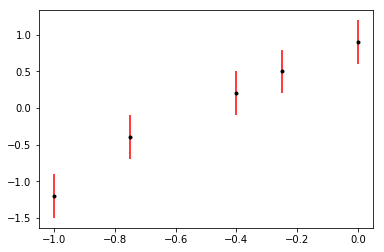

In [151]:
# We have some data with some uncertainty and we want to predict some other data
x = np.array([-1, -0.75, -0.4, -0.25, 0])
y = np.array([-1.2, -0.4, 0.2, 0.5, 0.9])
err = 0.3
plt.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")

goal_x = np.array([0.1])

In [180]:
# We can define a covariance function that describes how similar points
# at different locations should be

# There are these two hyperparameters
max_covariance = 1.27
length_scale = 0.1

def covariance_function(x):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    basic_cov = max_covariance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    data_err_cov = np.identity(len(x)) * err**2
    return basic_cov + data_err_cov


In [181]:
# We can build up the covariance matrix for the known data + the test data
# Also need a mean
mean = 0
cov_matrix = covariance_function(np.concatenate((x, goal_x)))

In [182]:
# We now have a mean and a covariance matrix - this is all we need to sample from a mv gaussian
# Our data y values are the samples in the first n dimensions of the mv gaussian
# We now need to take the sample for the final, test dimension.
# However, the probability for draws in that dimension depend on what we got for all the previous draws
# They are correlated
# We (I can't yet...) can do some matrix algebra to find what p(test_y_value | training_y_values)

cov_test_with_data = cov_matrix[-1 ,:-1]
cov_data_with_data = cov_matrix[:-1,:-1]
cov_test_with_test = cov_matrix[-1 , -1]

pred_y = np.dot(cov_test_with_data, np.matmul(np.linalg.inv(cov_data_with_data), y))
print(pred_y)

var_y = cov_test_with_test - np.dot(
    cov_test_with_data, np.matmul(
        np.linalg.inv(cov_data_with_data), cov_test_with_data))
print(var_y)

0.8300935331811287
0.25985606279864437


## Predict a large numpy of data points

In [183]:
goals = np.linspace(-1.5, 2, num=50)
pred_ys = []
var_ys = []
for gx in goals:
    cov_matrix = covariance_function(np.concatenate((x, [gx])))
    cov_test_with_data = cov_matrix[-1 ,:-1]
    cov_data_with_data = cov_matrix[:-1,:-1]
    cov_test_with_test = cov_matrix[-1 , -1]

    pred_ys.append(np.dot(cov_test_with_data, np.matmul(np.linalg.inv(cov_data_with_data), y)))

    var_ys.append(cov_test_with_test - 
                  np.dot(cov_test_with_data, 
                         np.matmul(np.linalg.inv(cov_data_with_data), cov_test_with_data)))

pred_ys = np.array(pred_ys)
var_ys = np.array(var_ys)

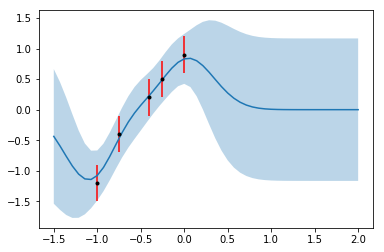

In [184]:
_, ax = plt.subplots()
ax.errorbar(x, y, yerr=err, linestyle="", marker=".", color="black", ecolor="red")

ax.plot(goals, pred_ys)
ax.fill_between(goals, pred_ys - np.sqrt(var_ys), pred_ys + np.sqrt(var_ys), alpha=0.3)